# Simulated MR artifacts (torchio)

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
%cd misas

/data3/ankenbrand/misas/misas


In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#default_exp mri

If you use these transformations which all build on TorchIO, please cite the following paper:
> Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696

In [ ]:
#exporti
from torchio.transforms import RandomSpike

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Link: https://arxiv.org/abs/2003.04696



## Spike artifact

In [ ]:
#exporti
from fastai.vision import open_image, Image, open_mask
from misas.core import Fastai1_model, get_generic_series, plot_series, eval_generic_series
from functools import partial
import torch

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
#export
def spikeTransform(image, intensityFactor, spikePosition=[.1,.1]):
    data = image.data[0].unsqueeze(0)
    spikePosition = [[0.0] + spikePosition]
    spike = RandomSpike()
    data = spike.add_artifact(data, spikePosition, intensityFactor)[0]
    data = torch.stack((data,data,data))
    return Image(torch.clamp(data,0,1))

def get_spike_series(image, model, start=0, end=2.5, step=.5, spikePosition=[.1,.1], **kwargs):
    return get_generic_series(image,model,partial(spikeTransform,spikePosition=spikePosition), start=start, end=end, step=step, **kwargs)

In [ ]:
fname = "example/b0/images/val_example_0.png"
img = lambda: open_image(fname).resize(256)
trueMask = lambda: open_mask(fname.replace("image","mask"))

In [ ]:
def interactiveSpikeTransform(intensity, x, y):
    spikeTransform(img(), intensity, [x,y]).show(figsize=(8,8))

In [ ]:
interactive_plot = interactive(
    interactiveSpikeTransform,
    intensity=widgets.FloatSlider(min=0, max=3, step=.1, value=1, continuous_update=True),
    x=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True),
    y=widgets.FloatSlider(min=0, max=.99, step=.05, value=.5, continuous_update=True)
)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='intensity', max=3.0), FloatSlider(value=0.5, descrip…

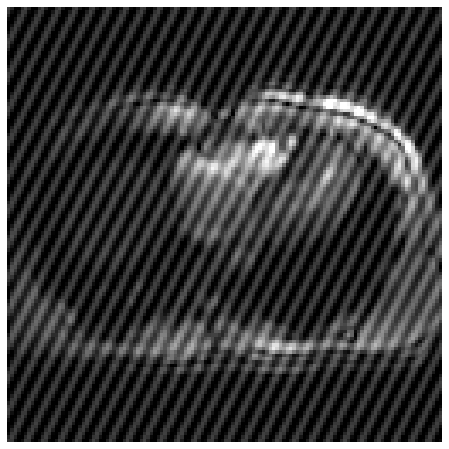

In [ ]:
spikeTransform(img, .8, [.4,.3]).show(figsize=(8,8), cmap="bone")

In [ ]:
trainedModel = Fastai1_model('chfc-cmi/transversal-cmr-seg', 'b0_transversal_5_5')

Using cache found in /home/ankenbrand/.cache/torch/hub/chfc-cmi_transversal-cmr-seg_master


In [ ]:
series = get_spike_series(img(), trainedModel, truth=trueMask(), tfm_y=False)

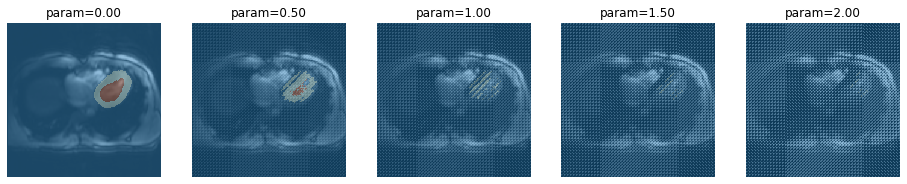

In [ ]:
plot_series(series)

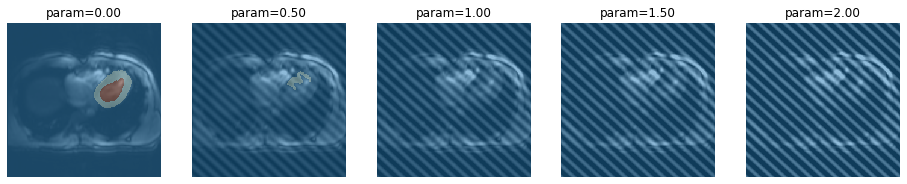

In [ ]:
spikePosition = [.45,.55]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

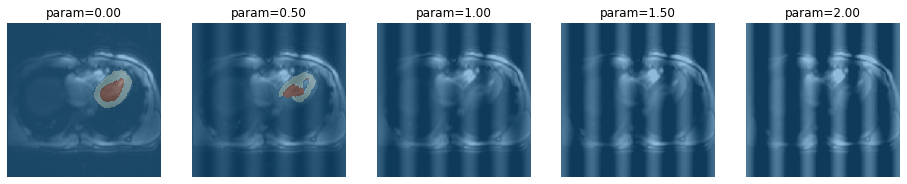

In [ ]:
spikePosition = [.5,.52]
plot_series(get_spike_series(img(), trainedModel, truth=trueMask(), spikePosition=spikePosition))

In [ ]:
#export
def eval_spike_series(image, mask, model, step=.1, start=0, end=2.5, spikePosition=[.1,.1], **kwargs):
    return eval_generic_series(
        image,
        mask,
        model,
        partial(spikeTransform,spikePosition=spikePosition),
        start=start,
        end=end,
        step=step,
        mask_transform_function=None,
        param_name="intensity",
        **kwargs
    )

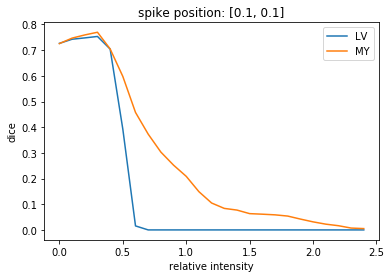

In [ ]:
results = eval_spike_series(img(), trueMask(), trainedModel)
plt.plot(results['intensity'], results['c1'], label='LV')
plt.plot(results['intensity'], results['c2'], label='MY')
plt.legend()
plt.xlabel('relative intensity')
plt.ylabel('dice')
_ = plt.title(f'spike position: {[.1,.1]}')